# Full-waveform inversion (FWI) with automated adjoint and checkpointing

Full-waveform inversion (FWI) is a technique in general employed to estimate the physical parameters in a subsurface region. It is a wave-equation-based seeking an optimal match between observed and computed data. The former is recorded by receivers in a real case. The latter consists of a computed data, which is obtained by solving numerically a wave equation with an forcing term representing a source of wave emission. 

## Functional to be minimised
A tradicional form to measure the difference between the observed and computed data is given by the functional (Tarantola, 1984): 
$$
    I(u, u^{obs}) = \sum_{r=0}^{N-1} \int_\Omega \left(u(c,\mathbf{x},t)- u^{obs}(c, \mathbf{x},t)\right)^2 \delta(x - x_r) \, dx
$$
where $u = u(c, \mathbf{x},t)$ and $u_{obs} = u_{obs}(c,\mathbf{x},t)$, are respectively the computed and observed data, both recorded at a finite number of receivers ($N_r$), located at the point positions $\check{\mathbf{x}} \in \Omega_{0}$, in a time interval $\tau\equiv[t_0, t_f]\subset \mathbb{R}$, where $t_0$ is the initial time and $t_f$ is the final time. The spatial domain of interest is set as $\Omega_{0}$.

An FWI problem consists in finding an optimal parameter $c$ that minimizes the functional $I(u, u^{obs})$.

## Wave equation
To have the computed data, we need first solve a wave equation. In this example, we consider the scalar acoustic wave equation using a damping term to attenate the reflections originated by the boundaries of the domain.
$$
    \frac{\partial^2 u}{\partial t^2}(\mathbf{x},t)- c^2\frac{\partial^2 u}{\partial \mathbf{x}^2} = f(\mathbf{x}_s,t) \tag{2}
$$
where $c(\mathbf{x}):\Omega_{0}\rightarrow \mathbb{R}$ is the pressure wave velocity, which is assumed here a piecewise-constant and positive. The source term $f(\mathbf{x}_s,t)$ represents a point of wave source.
The wave equation (2) satisfies the boundary conditions:
$$
    u(\mathbf{x},t) = 0, \quad \mathbf{x} \in \partial\Omega_{0}, \quad t\in\tau
$$
The acoustic wave equation should satisfy the initial conditions $u(\mathbf{x}, 0)  = 0 = u_t(\mathbf{x}, 0) = 0$.

To solve the wave equation, we consider the following weak form over the domain $\Omega_{0}$:
$$
    \int_{\Omega_{0}} \left(\frac{\partial^2 u}{\partial t^2}v + c^2\nabla u \cdot \nabla v\right) \, dx = \int_{\Omega_{0}} f v \, dx,
$$
for an arbitrary test function $v\in V$, where $V$ is a function space. The implementation of the weak form is given by the following Firedrake code:

In [1]:
import finat
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["PETSC_DIR"] = "/opt/petsc/firedrake"
os.environ["PETSC_ARCH"] = "full-opt"
os.environ["HDF5_DIR"] = "/opt/petsc/firedrake/packages"

from firedrake import *


def wave_equation_solver(c, source_function, dt, V):
    """Solves the acoustic wave equation in 2D.

    Parameters
    ----------
    c : velocity field
        The velocity field.
    source_function : firedrake.Function
        The function that models the source of the wave.
    dt : float
        The time step.
    V : firedrake.FunctionSpace
        The function space where the solution lives.

    Returns
    -------
    firedrake.LinearVariationalSolver, firedrake.Function, firedrake.Function, firedrake.Function
        Return the linear variational solver and the functions for the solution at time `n+1`, `n` and `n-1`.
        These outputs are going to be used in a time loop.
    
    Notes
    -----
    Additional information about this wave equation solver, including the discretisation and the
    linear variational problem, please refer this 
    `documentation link <https://www.firedrakeproject.org/demos/higher_order_mass_lumping.py.html>`_.
    """
    u = TrialFunction(V)
    v = TestFunction(V)

    u_np1 = Function(V) # timestep n+1
    u_n = Function(V) # timestep n
    u_nm1 = Function(V) # timestep n-1

    # quadrature rule for lumped mass matrix
    quad_rule = finat.quadrature.make_quadrature(V.finat_element.cell, V.ufl_element().degree(), "KMV")
    dudt2 =  (1 / (c * c)) * (u - 2.0 * u_n + u_nm1) / Constant(dt**2) * v * dx(scheme=quad_rule)
    nf =  (1 / c) * ((u_n - u_nm1) / dt) * v * ds
    a = dot(grad(u_n), grad(v)) * dx(scheme=quad_rule)
    F = dudt2 + a + nf - source_function * v * dx(scheme=quad_rule)
    lhs_ = lhs(F)
    rhs_ = rhs(F)
    lin_var = LinearVariationalProblem(lhs_, rhs_, u_np1)
    solver = LinearVariationalSolver(lin_var, solver_parameters={"ksp_type": "preonly", "pc_type": "jacobi"})
    return solver, u_np1, u_n, u_nm1

The wave euqation forcing $f = f(\mathbf{x}_s, t)$ represents a time-dependent wave source locate at the position $\mathbf{x}_s$, being written of the form:
$$
    f(\mathbf{x}_s,t) = r(t) \delta(\mathbf{x} - \mathbf{x}_s)
$$
where $r(t)$ is the [Ricker wavelet](https://wiki.seg.org/wiki/Dictionary:Ricker_wavelet), and $\delta(\mathbf{x} - \mathbf{x}_s)$ is the Dirac delta function. This forcing term is implemented in Firedrake as follows:

In [2]:
import numpy as np
from firedrake.__future__ import Interpolator

def forcing(parent_mesh, delta_loc, V):
    vom_mesh = VertexOnlyMesh(parent_mesh, [delta_loc])
    vom_space = FunctionSpace(vom_mesh, "DG", 0)
    forcing_point = assemble(Constant(1.0)*TestFunction(vom_space)*dx)
    interp = Interpolator(TestFunction(V), vom_space)
    return interp, forcing_point

The implementation of [Ricker wavelet](https://wiki.seg.org/wiki/Dictionary:Ricker_wavelet) is given by the following Firedrake code:

In [3]:
def ricker_wavelet(t, fs, amp=1.0):
    """Ricker wavelet.

    Parameters
    ----------
    t : float
        Time.
    fs : float
        Frequency.
    amp : float, optional
        Amplitude of the wavelet.

    Returns
    -------
    float
        The value of the wavelet at time `t`.
    """
    ts = 1.5
    t0 = t - ts * np.sqrt(6.0) / (np.pi * fs)
    return (amp * (1.0 - (1.0 / 2.0) * (2.0 * np.pi * fs) * (2.0 * np.pi * fs) * t0 * t0)
            * np.exp(
                (-1.0 / 4.0) * (2.0 * np.pi * fs) * (2.0 * np.pi * fs) * t0 * t0
            )
        )

## FWI execution
In this example, we consider a two dimensional domain where we want to estimate the parameter $c$ in a physical domain with the lenght of $1$ km ($L_x = 1km$) and the depth of $1$ km ($L_z = 1km$).

Below we create a dictionary containing the parameters necessary to solve the wave equation. The `model` dictionary contains the keys containing the basic setup to execute the acoust wave equation, and the FWI.

In addition, we create a `plot_function` used to plot the solutions and the parameter $c$ in the nexts code cells.

In [4]:
%matplotlib inline
from firedrake.pyplot import tricontourf
import matplotlib.pyplot as plt
Lx, Lz = 1, 1
num_receivers = 10
num_sources = 3
model = {
    "source_locations": np.linspace((0.3, 0.15), (0.7, 0.15), num_sources),
    "receiver_locations": np.linspace((0.2, 0.8), (0.8, 0.8), num_receivers),
    "mesh": UnitSquareMesh(60, 60),
    "dt": 0.002,  # time step
    "final_time": 0.8,  # final time
    "functional": None,  # The functional to be used in the inversion. Must be a callable.
    "syntetic_receiver_data": None,  # The syntetic receiver data to be used in the inversion.
    "frequency_peak": 7.0,  # The dominant frequency of the source.
}

def plot_function(function):
    # NBVAL_IGNORE_OUTPUT
    fig, axes = plt.subplots()
    contours = tricontourf(function, 10, axes=axes)
    fig.colorbar(contours, ax=axes, fraction=0.01, cmap="seismic")
    plt.gca().invert_yaxis()
    axes.set_aspect("equal")
    

As we mentioed before, an FWI problem consists in finding an optimal parameter $c$ that minimises the functional $I(u, u^{obs})$, where $u^{obs}$ is the observed data. In this example, we consider this observed data as a synthetic data, which is obtained by solving the wave equation with a known parameter $c_{true}$. For the sake of simplicity, we consider the velocity model consisting of a circle in the center of the domain as shown in the next code cell.

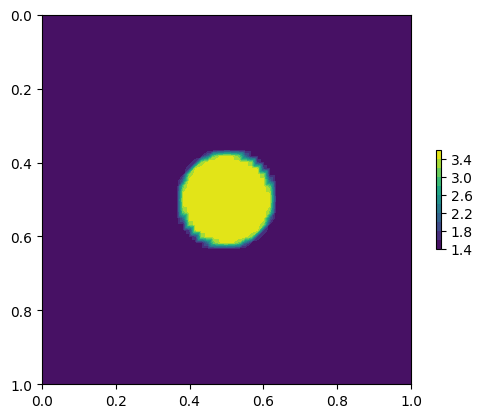

In [5]:
V = FunctionSpace(model["mesh"], "KMV", 1)
x, z = SpatialCoordinate(model["mesh"])
c_true = Function(V).interpolate(2.5 + 1 * tanh(200 * (0.125 - sqrt((x - 0.5) ** 2 + (z - 0.5) ** 2))))
plot_function(c_true)

Next, we get the synthetic data recorded on the receivers by executing the wave equation with the true syntetic $c_{true}$.

In [6]:
def true_receiver_data(syntetic_pressure, receiver_locations, source_locations, receiver_mesh):
    """Compute the syntetic receiver data.

    Parameters
    ----------
    syntetic_pressure : Function
        The syntetic pressure field.
    receiver_locations : array_like
        The receiver locations.
    
    receiver_mesh : firedrake.VertexOnlyMesh
        The receiver mesh.
    

    Returns
    -------
    list
        The syntetic receiver data for all time steps.
    """
    element = FiniteElement("KMV", model["mesh"].ufl_cell(), degree=1, variant="KMV")
    V = FunctionSpace(model["mesh"], element)
    source_function = Function(V)
    solver, u_np1, u_n, u_nm1 = wave_equation_solver(c_true, source_function, model["dt"], V)
    interpolator_sources, forcing_point = forcing(model["mesh"], source_locations, V)
    P0DG = FunctionSpace(receiver_mesh, "DG", 0)
    interpolator_receivers = Interpolator(u_np1, P0DG)
    u_sol_receivers = []
    for t in np.arange(0, model["final_time"] + model["dt"], model["dt"]):
        forcing_point.dat.data[:] = ricker_wavelet(t, model["frequency_peak"])
        source_function.assign(
            1000*assemble(
            interpolator_sources.interpolate(forcing_point, transpose=True)
            ).riesz_representation(riesz_map='l2')
        )
        # Call the solver object.
        solver.solve()
        # Interpolate the solution at the receiver locations and store the result.
        # This data will be used in the inversion to compute the functional.
        u_sol_receivers.append(assemble(interpolator_receivers.interpolate()))
        # Update the solution at the previous time steps.
        u_nm1.assign(u_n)
        u_n.assign(u_np1)
    return u_sol_receivers

receiver_mesh =  VertexOnlyMesh(model["mesh"], model["receiver_locations"])
u_sol_sources = []
num_sources = model["source_locations"].shape[0]
for sn in range(num_sources):
    print(f"Computing syntetic receiver data for source {sn+1} of {num_sources}")
    u_sol_sources.append(true_receiver_data(c_true, model["receiver_locations"], model["source_locations"][sn], receiver_mesh))

Computing syntetic receiver data for source 1 of 3
Computing syntetic receiver data for source 2 of 3
Computing syntetic receiver data for source 3 of 3


We now seeks to run a FWI problem, which involves the following steps:
1. Set the initial guess for the parameter $c$;
2. Solve the wave equation with the initial guess for the parameter $c$;
3. Compute the functional $I(u, u^{obs})$;
4. Compute the gradient of the functional $I(u, u^{obs})$ with respect to the parameter $c$;
5. Update the parameter $c$ using a gradient-based optimization method;

The gradient is computed automatically using the algorithmic differentiation (AD) pyadjoint. To have the automated gradient computation, we need to tape the forward solver associate to the paremeter $c$, which minimises the functional $I(u, u^{obs})$. Taping the forward solver starts when we set `continue_annotation()`.

FWI has extensive memory usage. To mitigate this issue, we can use the checkpointing technique. An FWI solver in firedrake is enabled to use the checkpointing technique by setting:
```python
    tape = get_working_tape()
    tape.enable_checkpointing(schedule)
```
where `schedule` is a checkpointing schedule.

The code cell below shows the definition of the checkpointing schedule and the command to enable the checkpointing technique. In the current example we are using the `Revolve` checkpoint schedule from the `checkpoint_schedule` package.

We set a progress bar to monitor the FWI run in time. 

<div class="alert alert-block alert-info">
<b>Note:</b> If you do not want to use checkpointing, you can skip the cell below.
</div>

The code cell below is forward solver for the guess parameter $c_{guess}$. This foward solver will tape by the algorithmic differentiation to compute the gradient of the functional $I(u, u^{obs})$.

In [7]:
from checkpoint_schedules import Revolve
from firedrake.adjoint import *

def J(c, true_receiver, source_location):
    continue_annotation()
    total_steps = int(model["final_time"] / model["dt"]) + 1
    tape = get_working_tape()
    tape.progress_bar = ProgressBar
    tape.enable_checkpointing(Revolve(total_steps, total_steps//10))
    element = FiniteElement("KMV", model["mesh"].ufl_cell(), degree=1, variant="KMV")
    V = FunctionSpace(model["mesh"], element)
    source_function = Function(V)
    solver, u_np1, u_n, u_nm1 = wave_equation_solver(c, source_function, model["dt"], V)
    interpolator_sources, forcing_point = forcing(model["mesh"], source_location, V)
    P0DG = FunctionSpace(receiver_mesh, "DG", 0)
    interpolator_receivers = Interpolator(u_np1, P0DG)
    J_val = 0.0
    for t in tape.timestepper(iter(range(total_steps))):
        forcing_point.dat.data[:] = ricker_wavelet(model["dt"] * t, model["frequency_peak"])
        source_function.assign(
            1000*assemble(
            interpolator_sources.interpolate(forcing_point, transpose=True)
            ).riesz_representation(riesz_map='l2')
        )
        solver.solve()
        u_nm1.assign(u_n)
        u_n.assign(u_np1)
        guess_receiver = assemble(interpolator_receivers.interpolate())
        J_val += 0.5 * assemble(
            inner(guess_receiver - true_receiver[t], guess_receiver - true_receiver[t]) * dx
            )
    return J_val

In [8]:
from scipy.optimize import minimize as scipy_minimize


def recompute_functional(reduced_functional):
    tape = reduced_functional.tape
    tape.reset_blocks()
    blocks = tape.get_blocks()
    with reduced_functional.marked_controls():
        if tape._checkpoint_manager:
            tape._checkpoint_manager.recompute(reduced_functional.functional)
        else:
            for i in tape._bar("Evaluating functional").iter(
                range(len(blocks))
            ):
                blocks[i].recompute()
    return reduced_functional.functional.block_variable.saved_output

J_hat_sources =[]
def run_fwi(c_guess):
    global iteration
    J_total = 0.0
    dJ_total = Function(V)
    num_sources = len(model["source_locations"])
    for sn in range(num_sources):
        print(f"Running source {sn + 1} of {len(model['source_locations'])}")
        if iteration == 0:
            vp_guess = Function(V)
            vp_guess.dat.data_wo[:] = c_guess
            Js = J(vp_guess, u_sol_sources[sn], model["source_locations"][sn])
            J_hat_sources.append(ReducedFunctional(Js, Control(vp_guess)))
            set_working_tape(Tape())
        else:
            with stop_annotating():
                J_hat_sources[sn].controls[0].update_numpy(c_guess, 0)
                Js = recompute_functional(J_hat_sources[sn])
        with stop_annotating():
            J_total += Js
            dJ_total += J_hat_sources[sn].derivative()
    iteration += 1     
    return J_total, dJ_total.dat.data[:]

iteration = 0
c = Function(V).interpolate(1.5)
bounds = [(1.5, 3.5)] * len(c.dat.data)
result_data = scipy_minimize(run_fwi, c.dat.data[:], method='L-BFGS-B',
                             jac=True, tol=1e-15, bounds=bounds,
                             options={"disp": True, "eps": 1e-15,
                                      "gtol": 1e-15, "maxiter": 10})
vp_end = Function(V)
vp_end.dat.data[:] = result_data.x
plot_function(vp_end)

Running source 1 of 3


Taping forward ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/100 [0:00:03]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:22]


Running source 2 of 3


Taping forward ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/100 [0:00:03]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:22]


Running source 3 of 3


Taping forward ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/100 [0:00:03]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:21]
Evaluating Functional ▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 28/401 [0:00:00]

Running source 1 of 3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3721     M =           10

At X0      3721 variables are exactly at the bounds

At iterate    0    f=  3.44508D-02    |proj g|=  3.73518D-03


Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:02]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:22]
Evaluating Functional ▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 29/401 [0:00:00]

Running source 2 of 3


Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:02]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:21]
Evaluating Functional ▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 27/401 [0:00:00]

Running source 3 of 3


Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:03]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:22]
Evaluating Functional ▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 27/401 [0:00:00]


At iterate    1    f=  3.42918D-02    |proj g|=  3.68781D-03
Running source 1 of 3


Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:03]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:21]
Evaluating Functional ▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 27/401 [0:00:00]

Running source 2 of 3


Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:03]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:22]
Evaluating Functional ▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 28/401 [0:00:00]

Running source 3 of 3


Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:03]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:22]
Evaluating Functional ▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 27/401 [0:00:00]


At iterate    2    f=  2.25942D-02    |proj g|=  1.19531D-03
Running source 1 of 3


Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:02]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:22]
Evaluating Functional ▣▣▣▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢▢ 28/401 [0:00:00]

Running source 2 of 3


Evaluating Functional ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣ 401/401 [0:00:02]
Evaluating Adjoint ▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▣▢▢▢▢▢ 368/401 [0:00:21]